In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram as hst, array_to_latex
import numpy as np
from numpy import pi
from qiskit.circuit.library import QFT
from qiskit.algorithms import VQE, NumPyEigensolver
from qiskit.circuit import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import SPSA
from qiskit.providers.basicaer import QasmSimulatorPy


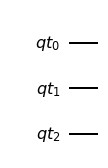

In [2]:
qt = QuantumRegister(3, 'qt')
qct = QuantumCircuit(qt)
%matplotlib inline
qct.draw(output = 'mpl')

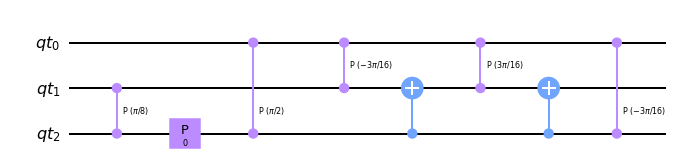

In [3]:
at = 0
bt = pi/2
ct = pi/8
dt = pi/4

qct.cp(ct - at, qt[2], qt[1])
qct.p(at, qt[2])
qct.cp(bt - at, qt[2], qt[0])

qct.cp((dt - ct + at - bt)/2, qt[1], qt[0])
qct.cx(qt[2], qt[1])
qct.cp(-(dt - ct + at - bt)/2, qt[1], qt[0])
qct.cx(qt[2], qt[1])
qct.cp((dt - ct + at - bt)/2, qt[2], qt[0])

qct.draw(output = 'mpl')


In [4]:
##unitary matrix

backend = Aer.get_backend('unitary_simulator')
job_unitary_t = execute(qct, backend, shots = 9000)
count_unitary_t = job_unitary_t.result().get_unitary()
array_to_latex(count_unitary_t, prefix="\\text{Circuit = }\n")

<IPython.core.display.Latex object>

In [5]:
#function to create C-Uj

def controlled_unitary(qc, qubits: list, phases: list):
    qc.cp(phases[2]-phases[0], qubits[0], qubits[1]) # controlled-U1(c-a)
    qc.p(phases[0], qubits[0]) # U1(a)
    qc.cp(phases[1]-phases[0], qubits[0], qubits[2]) # controlled-U1(b-a)
    
    #CC-U1(d-c+a-b)
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp(-(phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[0], qubits[2])

In [6]:
#for U = U1*U2*U3*U4; *--> Tensor product

def U(times, qc, unit, eigen, phases: list): # a,b,c = phases for U1; d,e,f = phases for U2; g,h,i = phases for U3; j,k,l = phases for U4; m_list=[m, n, o, p, q, r, s, t, u, a, b, c, d, e, f, g, h, i, j, k, l]
    controlled_unitary(qc, [unit[0]]+eigen[0:2], [0]+phases[0:3])
    controlled_unitary(qc, [unit[0]]+eigen[2:4], [phases[3]]+[0]+phases[4:6])
    controlled_unitary(qc, [unit[0]]+eigen[4:6], phases[6:8]+[0]+[phases[8]])
    controlled_unitary(qc, [unit[0]]+eigen[6:8], phases[9:12]+[0])

In [7]:
#now finally for CU^{2,4,8,16,32} to account for the sum of all possible paths

def final_U(times, eigen, phases: list):
    unit = QuantumRegister(1, 'unit')
    qc = QuantumCircuit(unit, eigen)
    for _ in range(2**times):
        U(times, qc, unit, eigen, phases)
    return qc.to_gate(label='U'+'_'+(str(2**times)))

In [8]:
##building the eigenstates

#storing the eigenvalues
eigen_values = ["11000110", "10001101", "11001001"]

# Function to place appropriate corresponding gate according to eigenstates
def eigenstates(qc, e, index): #e is a defined eigenvalue in code, whose state is being changed based on whether at the corresponding index in our defined eigenstates there is a 1.
    for i in range(0, len(e)):
        if eigen_values[index][i] == '1':
            qc.x(e[i])
        if eigen_values[index][i] == '0':
            pass
    qc.barrier()
    return qc

In [12]:
##now finally moving on to our Quantum Circu#setting up the first distinct eigenstate, which is 11000110

result = np.zeros((len(eigen_values),len(eigen_values)))

for i in range(0,len(eigen_values)):
    
# Initialization
    
    unit = QuantumRegister(6, 'unit')
    eigen = QuantumRegister(8, 'eigen')
    unit_classical = ClassicalRegister(6, 'unit_classical')
    qc = QuantumCircuit(unit, eigen, unit_classical)
    
    
    eigenstates(qc, eigen, i)
    
# Hadamard on the 'unit' qubits
    qc.h(unit[:])
    qc.barrier()

# C-U
    phases = [pi / 2, pi / 8, pi / 4, pi / 2, pi / 4, pi / 4, pi / 8, pi / 4, pi / 8, pi / 4, pi / 4, pi / 8] # a, b, c, d, e, f, g, h, i, j, k, l
    for j in range(0, 6):
        qc.append(final_U(j, eigen, phases), [unit[5-j]] + eigen[:])

# Inverse QFT 
    qc.barrier()
    qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
    qc.append(qft, qc.qubits[:len(unit)])
    qc.barrier()

#measurement 
    qc.measure(unit, unit_classical)
    
#execution
    backend = Aer.get_backend('qasm_simulator')
    count = execute(qc, backend, shots = 1024).result().get_counts()
    result[i][i] = str(count.most_frequent())


# result = result.astype('int64')
# qc.draw(output = 'mpl')
print(result)
    

[[100100.      0.      0.]
 [     0. 100000.      0.]
 [     0.      0. 100000.]]


In [371]:
# VQE

#op = Operator(qc)
op = Operator(result)
#backend = BasicAer.get_backend("statevector_simulator")
ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement="linear", insert_barriers=True)
optimizer = SPSA(maxiter=100)
np.random.seed(5)  # fix seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)
#op = Operator(final_U(1, eigen, phases))
#exact_solution = NumPyEigensolver(operator).run()
vqe = VQE(ansatz=ansatz, optimizer=optimizer, initial_point=initial_point, gradient=None, expectation=None, include_custom=False, max_evals_grouped=1024, callback=None, quantum_instance=QasmSimulatorPy())
#result = vqe.get_optimal_cost(initial_point=None, ansatz=None, cost_fn=op, optimizer=None, gradient_fn=None)
#vqe_result = np.real(vqe.run(QuantumInstance(backend)))
min_distance = vqe.compute_minimum_eigenvalue(operator = op, aux_operators = None)
print(_)

CircuitError: 'Exactly one of the size or bits arguments can be provided. Provided size=None bits=None.'